# 출처 : 
https://github.com/PeterKim1/paper_code_review/blob/master/2.%20Auto-Encoding%20Variational%20Bayes(VAE)/2_Auto_Encoding_Variational_Bayes(VAE).ipynb

# Training

In [1]:
%matplotlib inline
import torch
import torchvision
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
from pytz import timezone
import os
import matplotlib.pyplot as plt

from dataset import DONGJIN, DongjinTransform
from model import VAE

/home/roseli/workspaces/runtimes/miniconda3/envs/dongjin/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/roseli/workspaces/runtimes/miniconda3/envs/dongjin/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:1833: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)

current_time = datetime.datetime.now(timezone('Asia/Seoul'))
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

#saved_loc = os.path.join('./outs', current_time)
#os.mkdir(saved_loc)
#print("저장 위치: ", saved_loc)
#writer = SummaryWriter(saved_loc)

iterate = True
EPOCHS = 3
BATCH_SIZE = 32
IMG_RESIZE = 480
COLOR_DEPTH = 1 # GrayScale
latent_size = 32
DATA_PATH = '/home/roseli/workspaces/projects/datavoucher/data'

train_dir = 'normal'
test_dir = 'anomaly'


사용하는 Device :  cuda:0


In [12]:
tf, tf_inv = DongjinTransform(IMG_RESIZE, (1250,400)).get()

# Loading trainset, testset and trainloader, testloader
trainset = DONGJIN(root = DATA_PATH, train = True, transform = tf, train_dir=train_dir, test_dir=test_dir)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


testset = DONGJIN(root = DATA_PATH, train = False, transform = tf, train_dir=train_dir, test_dir=test_dir)
testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [13]:
# [FOR DEBUG]sample check
sample, label, meta = next(iter(trainloader))
len(trainset)

7125

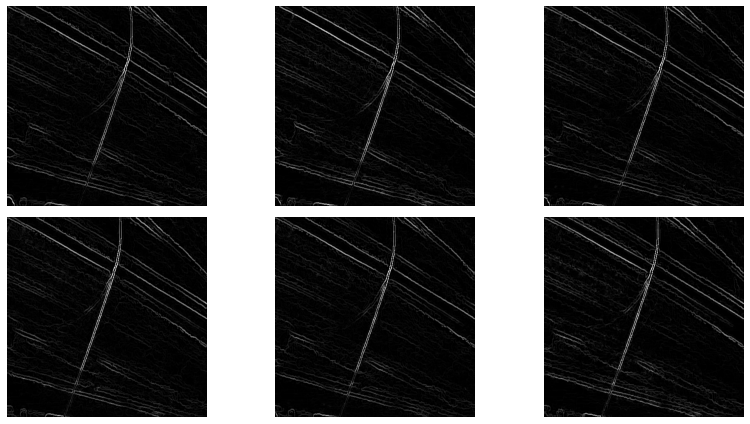

In [14]:
# [FOR DEBUG]show image
def imshow_grid(imgs, tf_inv=None):
    figure, axes = plt.subplots(2, 3, figsize=(12,6))
    ax = axes.flatten()
    for i, im in enumerate(imgs):
        if tf_inv:
            ax[i].imshow(tf_inv(im), cmap='gray')
        else:
            ax[i].imshow(im, cmap='gray')
        ax[i].axis('off')
    figure.tight_layout()
    plt.show()

imshow_grid(sample[0:6], tf_inv)

In [15]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, IMG_RESIZE*IMG_RESIZE*COLOR_DEPTH), reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [21]:
def train(epoch, model, train_loader, optimizer, name=None):
    model.train()
    train_loss = 0
    for batch_idx, (data, _, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        #recon_batch = torch.reshape(recon_batch, (-1, COLOR_DEPTH, IMG_RESIZE, IMG_RESIZE))
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)

        loss = BCE + KLD

        writer.add_scalar("Train/Reconstruction Error", BCE.item() / len(data), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
        writer.add_scalar("Train/KL-Divergence", KLD.item() / len(data), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )
        writer.add_scalar("Train/Total Loss" , loss.item() / len(data), batch_idx + epoch * (len(train_loader.dataset)/BATCH_SIZE) )

        loss.backward()

        train_loss += loss.item()

        optimizer.step()

        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss.item() / len(data)))
            
    print("{}======> Epoch: {} Average loss: {:.4f}".format(
        name if name else '=', epoch, train_loss / len(train_loader.dataset)
    ))        
    return train_loss / len(train_loader.dataset)

In [22]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _, _) in enumerate(test_loader):
            data = data.to(DEVICE)
            
            recon_batch, mu, logvar = model(data)
            #recon_batch = torch.reshape(recon_batch, (-1, COLOR_DEPTH, IMG_RESIZE, IMG_RESIZE))
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)

            loss = BCE + KLD

            writer.add_scalar("Test/Reconstruction Error", BCE.item() / len(data), batch_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
            writer.add_scalar("Test/KL-Divergence", KLD.item() / len(data), batch_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
            writer.add_scalar("Test/Total Loss" , loss.item() / len(data), batch_idx + epoch * (len(test_loader.dataset)/BATCH_SIZE) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(data.size(0), 6)
                comparison = torch.cat([data[:n], recon_batch.view(-1, COLOR_DEPTH, IMG_RESIZE, IMG_RESIZE)[:n]]) # (16, 1, 28, 28)
                grid = torchvision.utils.make_grid(comparison.cpu()) # (3, 62, 242)
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
    return test_loss / len(test_loader.dataset)

In [23]:
def latent_to_image(save_loc, model, latent_size):
    with torch.no_grad():
        sample = torch.randn(6, latent_size).to(DEVICE)
        recon_image = model.decode(sample).cpu()
        grid = torchvision.utils.make_grid(recon_image.view(-1, COLOR_DEPTH, IMG_RESIZE, IMG_RESIZE))

        plt.imshow(grid.permute(1,2,0))
        plt.savefig(os.path.join(save_loc, 'sample.png'))
        # writer.add_image("Latent To Image", grid, epoch)


저장 위치:  ./outs/2022-08-30-19:26


  0%|          | 0/3 [00:00<?, ?it/s]

Experiment # 1 / 1 : saved at ./outs/2022-08-30-19:26======> Epoch: 0 Average loss: 37566.9238


/home/roseli/workspaces/runtimes/miniconda3/envs/dongjin/lib/python3.7/site-packages/torch/utils/tensorboard/summary.py:423: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((scaled_width, scaled_height), Image.ANTIALIAS)
 33%|███▎      | 1/3 [38:23<1:16:47, 2303.64s/it]

Experiment # 1 / 1 : saved at ./outs/2022-08-30-19:26======> Epoch: 1 Average loss: 31677.6095


/home/roseli/workspaces/runtimes/miniconda3/envs/dongjin/lib/python3.7/site-packages/torch/utils/tensorboard/summary.py:423: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((scaled_width, scaled_height), Image.ANTIALIAS)
 67%|██████▋   | 2/3 [1:17:04<38:34, 2314.03s/it]

Experiment # 1 / 1 : saved at ./outs/2022-08-30-19:26======> Epoch: 2 Average loss: 31011.9154


/home/roseli/workspaces/runtimes/miniconda3/envs/dongjin/lib/python3.7/site-packages/torch/utils/tensorboard/summary.py:423: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((scaled_width, scaled_height), Image.ANTIALIAS)
100%|██████████| 3/3 [1:54:54<00:00, 2298.13s/it]


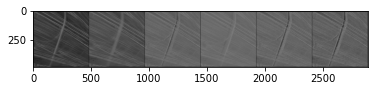

In [24]:
# epochs = [3, 10, 100]
# bsize = [16, 64]
# latent = [2, 32, 128]
epochs= [3]
bsize= [16]
latent = [2]
exp_num = 1
total_exp = len(epochs)*len(bsize)*len(latent)
if iterate:
    for e in epochs:
        for b in bsize:
            for l in latent:

                current_time = datetime.datetime.now(timezone('Asia/Seoul'))
                current_time = current_time.strftime('%Y-%m-%d-%H:%M')

                saved_loc = os.path.join('./outs', current_time)
                if not os.path.exists(saved_loc):
                    os.mkdir(saved_loc)

                print("저장 위치: ", saved_loc)
                    
                # Loading trainset, testset and trainloader, testloader
                trainset = DONGJIN(root = DATA_PATH, train = True, transform = tf, train_dir=train_dir, test_dir=test_dir)
                trainloader = torch.utils.data.DataLoader(trainset, batch_size = b, shuffle = True, num_workers = 2)

                testset = DONGJIN(root = DATA_PATH, train = False, transform = tf, train_dir=train_dir, test_dir=test_dir)
                testloader = torch.utils.data.DataLoader(testset, batch_size = b, shuffle = True, num_workers = 2)

                writer = SummaryWriter(saved_loc)

                # Model and training settings
                VAE_model = VAE(IMG_RESIZE*IMG_RESIZE*COLOR_DEPTH, 512, 256, l).to(DEVICE)
                lr = 1e-4 if e < 10 else 1e-5
                optimizer = optim.Adam(VAE_model.parameters(), lr = lr)

                # train/test
                for epoch in tqdm(range(0, e)):
                    train_loss = train(epoch, VAE_model, trainloader, optimizer, name=f'Experiment # {exp_num} / {total_exp} : saved at {saved_loc}')
                    test_loss = test(epoch, VAE_model, testloader)
                
                # save sample image and model
                latent_to_image(saved_loc, VAE_model, l)

                torch.save({
                    'epoch':e,
                    'model_state_dict':VAE_model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'train_loss': train_loss,
                    'test_loss' : test_loss,
                    'batch_size':b,
                    'leargning_rate':lr,
                    'latent_dim':l,
                    'img_resize':IMG_RESIZE
                    }, os.path.join(saved_loc, 'model.pt'))

                writer.close()
                exp_num += 1

In [ ]:
if not iterate:
    VAE_model = VAE(IMG_RESIZE*IMG_RESIZE*COLOR_DEPTH, 512, 256, latent_size).to(DEVICE)
    optimizer = optim.Adam(VAE_model.parameters(), lr = 1e-4)
    for epoch in tqdm(range(0, EPOCHS)):
        train(epoch, VAE_model, trainloader, optimizer)
        test(epoch, VAE_model, testloader)
        print("\n")
        latent_to_image(epoch, VAE_model)

    writer.close()

# Anomaly Scoring

In [30]:
%matplotlib inline
import torch
import torchvision
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
from pytz import timezone
import os
import matplotlib.pyplot as plt

from dataset import DONGJIN, DongjinTransform
from model import VAE

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)
DATA_PATH = '/home/roseli/workspaces/projects/datavoucher/data'


사용하는 Device :  cuda:0


In [31]:
# load model
save_loc = 'outs/2022-08-30-19:26/model.pt'
ckpt = torch.load(save_loc)
latent_dim = ckpt['latent_dim']
image_size = ckpt['img_resize']
batch_size = ckpt['batch_size']
model = VAE(image_size*image_size, 512, 256, latent_dim).to(DEVICE) # (input_size, 512, 256, latent_size)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()
# save sample decoder image

VAE(
  (fc1): Linear(in_features=230400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=230400, bias=True)
)

In [40]:
# anomaly images 폴더 이름 test-images로 변경하고 로드
tf, _ = DongjinTransform(image_size).get()
testset = DONGJIN(root = DATA_PATH, train = False, transform = tf, train_dir='normal', test_dir='all')
testloader = torch.utils.data.DataLoader(testset, batch_size = ckpt['batch_size'], shuffle = False, num_workers = 2)
## TODO: index 순서 맞음?

In [41]:
import time
# anomaly graph 후보1. 디코터까지 전부 통과시킨 결과물 비교하기
# ref : https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return F.l1_loss(v1, v2, reduce=False)

def estimate(model, test_loader):
    """
    predict all batch and draw anomaly graph
    """
    anomaly_scores = []
    anomaly_results = []
    frame_count = []
    im_paths = []

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _, meta) in enumerate(test_loader):
            data = data.to(DEVICE)   
            t = time.time()
            pred, _, _ = model(data)
            t = time.time() - t
            pred = torch.reshape(pred, (-1, 1, image_size, image_size))

            mae_vector_test = get_error_term(pred, data, _rmse=False)
            mae_vector_test = torch.mean(mae_vector_test, (1,2,3))
            error_thresh = torch.quantile(mae_vector_test, 0.99)
            anomalies = (mae_vector_test >= error_thresh).float()

            frame_count += [int(i) for i in meta['frame_num']]
            im_paths += meta['img_path']
            anomaly_scores += mae_vector_test.cpu().numpy().tolist()
            anomaly_results += anomalies.cpu().numpy().tolist()

            if batch_idx % 10 == 0:
                print(f'{batch_size * batch_idx} / {len(testset)}' )
                print(f'fps : {1.0 / (t/data.size()[0])}')
    plt.figure(figsize=(18,6))
    plt.plot(sorted(zip(frame_count, anomaly_scores), key=lambda x: x[0]))
    plt.plot(sorted(zip(frame_count, anomaly_results), key=lambda x: x[0]))
    plt.show()

    return frame_count, anomaly_scores, anomaly_results, im_paths
            

In [43]:
x, y1, y2, impaths = estimate(model, testloader)

/home/roseli/workspaces/runtimes/miniconda3/envs/dongjin/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0 / 7192
fps : 6332.219664087564


In [44]:
len(impaths)
# sorted(zip(x, y1), key=lambda x:x[0])

7192

In [45]:
print(x[:10])

[2110, 1090, 5002, 5735, 2163, 1704, 2376, 6225, 847, 5152]


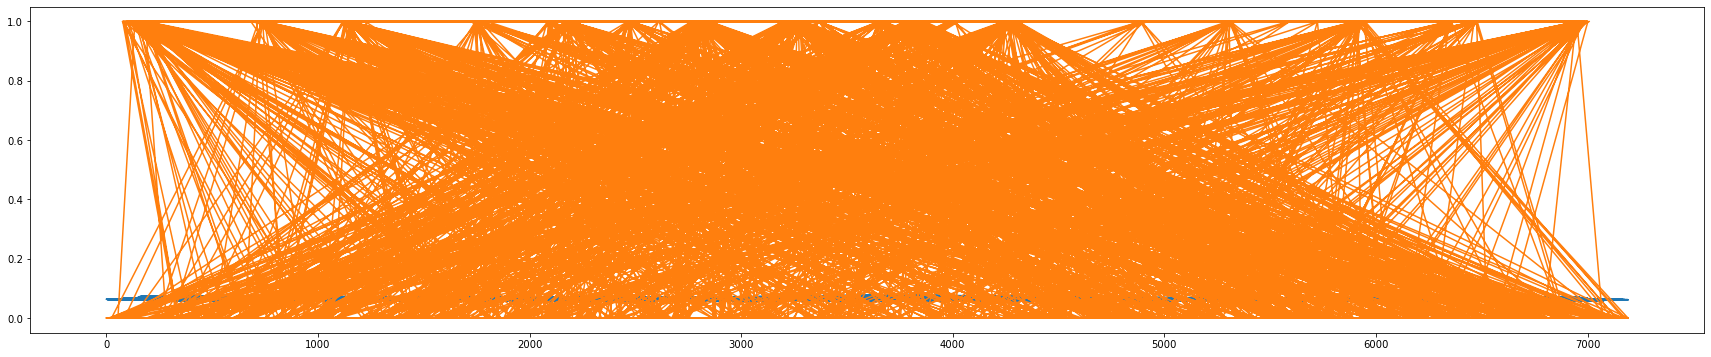

In [46]:
thres = 0.065
plt.figure(figsize=(30,6))
plt.plot(x, y1)
# plt.yticks(np.arange(0.1,0.3,step=0.02))
y3 = (np.array(y1) > thres)
# plt.plot(x, y2) # auto estimated threshold
plt.plot(x, y3) # auto estimated threshold
plt.show()

In [47]:
# 실제 정답 프레임은 4278~4281 (8555~8580) (XRN-1610SA_philo_15880-Cam01_20220726_145500_20220726_145900_ID_0000.avi)
# 3 프레임마다 하나 저장했는데 왜 2400장 밖에 없지? 다시확인필요

In [48]:
anomaly_frame_num = np.where(np.array(y1) > thres)

im_path = impaths[int(anomaly_frame_num[0])]

print(im_path)


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
cnt = 0

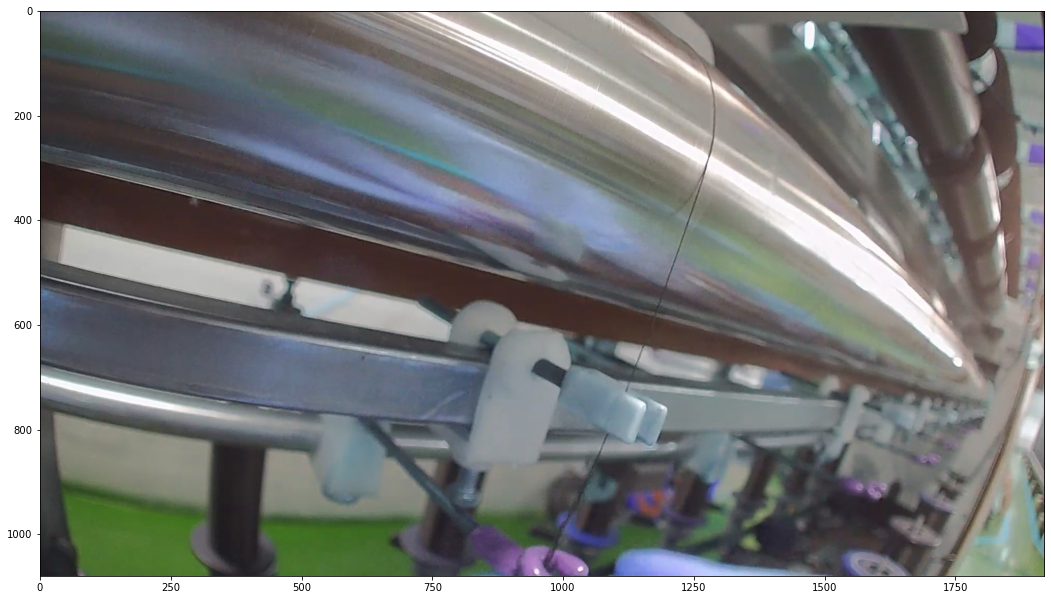

In [ ]:
%matplotlib inline
from PIL import Image
from matplotlib import pyplot as plt


for frame in anomaly_frame_num[0]:
    # im = Image.open(os.path.join(DATA_PATH, 'DONGJIN/raw/anomaly-all-images/',im_path))
    im = Image.open(os.path.join(DATA_PATH, 'DONGJIN/raw/anomaly-all-images/', f'XRN-1610SA_philo_15880-Cam01_20220726_145500_20220726_145900_ID_0000.avi_004232.jpg'))

    plt.figure(figsize=(18,18))
    plt.imshow(im)
cnt += 1

In [ ]:
# anmoaly graph visualization 후보2. 인코더에 통과시킨 latent dim으로 비교하기
# from sklearn.decomposition import PCA
# X_encoded = VAE_model.encoder(X_test)
# pca = PCA(n_components=2)
# X_transform = pca.fit_transform(X_encoded)